<a href="https://colab.research.google.com/github/deepw98/project2/blob/main/Project2.P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cp -r /content/drive/MyDrive/fire_detection_few_shot /content/fire_detection_few_shot

In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Lambda, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
import pickle


In [4]:
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    return img

In [5]:
def load_dataset(dataset_path, batch_size=32, img_size=(224, 224)):
    dataset = image_dataset_from_directory(
        dataset_path,
        image_size=img_size,
        batch_size=batch_size
    )
    return dataset


In [6]:
def create_feature_extractor():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    outputs = Dense(128, activation=None)(x)
    model = Model(inputs, outputs)
    return model


In [7]:
def pairwise_distances(embeddings):
    return tf.norm(tf.expand_dims(embeddings, axis=1) - tf.expand_dims(embeddings, axis=0), axis=-1)


In [8]:
def hard_pair_mining(embeddings, labels):
    distances = pairwise_distances(embeddings)
    pos_mask = tf.equal(tf.expand_dims(labels, axis=1), tf.expand_dims(labels, axis=0))
    neg_mask = tf.logical_not(pos_mask)

    hardest_positive = tf.reduce_max(tf.where(pos_mask, distances, tf.zeros_like(distances)), axis=1)
    hardest_negative = tf.reduce_min(tf.where(neg_mask, distances, tf.fill(tf.shape(distances), tf.float32.max)), axis=1)
    return hardest_positive, hardest_negative


In [9]:
def prototypical_loss(y_true, embeddings):
    hardest_positive, hardest_negative = hard_pair_mining(embeddings, y_true)
    loss = tf.maximum(hardest_positive - hardest_negative + 0.2, 0.0)
    return tf.reduce_mean(loss)

In [10]:
def train_model(dataset_path, epochs=10, save_path="embeddings.pkl"):
    dataset = load_dataset(dataset_path)
    feature_extractor = create_feature_extractor()
    optimizer = Adam(learning_rate=0.001)

    all_embeddings = {}

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_embeddings = []
        epoch_labels = []

        for images, labels in dataset:
            with tf.GradientTape() as tape:
                embeddings = feature_extractor(images)
                loss = prototypical_loss(labels, embeddings)

            gradients = tape.gradient(loss, feature_extractor.trainable_variables)
            optimizer.apply_gradients(zip(gradients, feature_extractor.trainable_variables))

            epoch_loss += loss.numpy()
            epoch_embeddings.append(embeddings.numpy())
            epoch_labels.append(labels.numpy())

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(dataset)}")

        all_embeddings[epoch + 1] = {
            "embeddings": np.concatenate(epoch_embeddings, axis=0),
            "labels": np.concatenate(epoch_labels, axis=0),
        }

    with open(save_path, "wb") as f:
        pickle.dump(all_embeddings, f)
    print(f"Embeddings saved to {save_path}")

    return feature_extractor  # Return trained model

# Train and get model
feature_extractor = train_model("/content/fire_detection_few_shot/train")


Found 294 files belonging to 2 classes.
Epoch 1/10, Loss: 19.381159782409668
Epoch 2/10, Loss: 110.07139282226562
Epoch 3/10, Loss: 18.06677362918854
Epoch 4/10, Loss: 1.9121021389961244
Epoch 5/10, Loss: 1.508787715435028
Epoch 6/10, Loss: 1.1489820957183838
Epoch 7/10, Loss: 0.26062317863106726
Epoch 8/10, Loss: 0.18753172159194947
Epoch 9/10, Loss: 0.4927556157112122
Epoch 10/10, Loss: 0.01201368346810341
Embeddings saved to embeddings.pkl


In [11]:
# train_model("/content/fire_detection_few_shot/train")

<ipython-input-12-a48e60b832b6>:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter([], [], cmap="coolwarm", alpha=0.7)


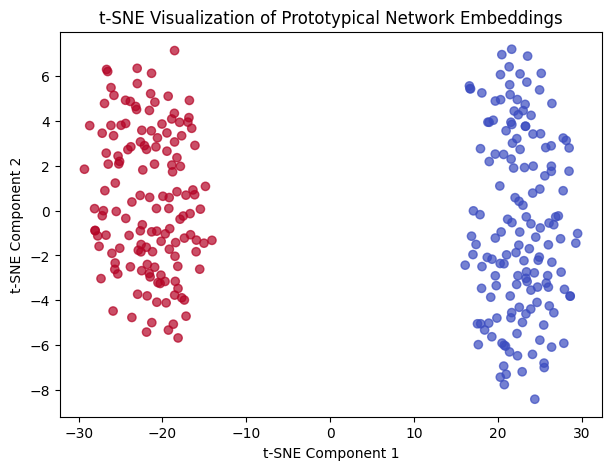

In [12]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.manifold import TSNE

# Load embeddings
with open("embeddings.pkl", "rb") as f:
    all_embeddings = pickle.load(f)

# Extract epochs
epochs = sorted(all_embeddings.keys())

# Apply t-SNE on embeddings for each epoch
tsne_results = {}
for epoch in epochs:
    embeddings = all_embeddings[epoch]["embeddings"]
    labels = all_embeddings[epoch]["labels"]

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    tsne_results[epoch] = tsne.fit_transform(embeddings)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(7, 5))
sc = ax.scatter([], [], cmap="coolwarm", alpha=0.7)
epoch_text = ax.text(0.05, 0.95, "", transform=ax.transAxes, fontsize=12, verticalalignment='top')

# Update function for animation
def update(epoch_idx):
    epoch = epochs[epoch_idx]
    tsne_emb = tsne_results[epoch]
    labels = all_embeddings[epoch]["labels"]

    ax.clear()
    scatter = ax.scatter(tsne_emb[:, 0], tsne_emb[:, 1], c=labels, cmap="coolwarm", alpha=0.7)
    epoch_text.set_text(f"Epoch: {epoch}")

    ax.set_title("t-SNE Visualization of Prototypical Network Embeddings")
    ax.set_xlabel("t-SNE Component 1")
    ax.set_ylabel("t-SNE Component 2")
    return scatter, epoch_text

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(epochs), interval=1000, repeat=True)

# Save animation as GIF (optional)
ani.save("tsne_animation.gif", writer="pillow", fps=2)

# Show animation
plt.show()


In [13]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [14]:
import os

test_folder = "/content/fire_detection_few_shot/test"
print("Files in test folder:", os.listdir(test_folder))

# Check Fire and No_Fire folders
fire_folder = os.path.join(test_folder, "Fire")
no_fire_folder = os.path.join(test_folder, "No_Fire")

print("🔥 Fire images:", os.listdir(fire_folder))
print("🚫 No_Fire images:", os.listdir(no_fire_folder))


Files in test folder: ['Fire', 'No_Fire']
🔥 Fire images: ['pic (157).jpg', 'small (102).jpg', 'small (21).jpg', 'pic (158).jpg', 'pic (156).jpg', 'small (23).jpg', 'small (22).jpg', 'pic (155).jpg', 'pic (159).jpg', 'small (103).jpg']
🚫 No_Fire images: ['NF_18.jpg']


In [15]:
import cv2

for folder in [fire_folder, no_fire_folder]:
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Corrupted or invalid file: {img_path}")


Corrupted or invalid file: /content/fire_detection_few_shot/test/No_Fire/NF_18.jpg


In [16]:
import os
import glob

no_fire_folder = "/content/fire_detection_few_shot/test/No_Fire"

# Check number of files
print(f"Expected files: 10, Found: {len(os.listdir(no_fire_folder))}")

# Check if files exist but are hidden
hidden_files = glob.glob(no_fire_folder + "/.*")
print("Hidden files:", hidden_files)

# Check if files are in a different format
all_files = glob.glob(no_fire_folder + "/*")
print("All detected files:", all_files)


Expected files: 10, Found: 1
Hidden files: []
All detected files: ['/content/fire_detection_few_shot/test/No_Fire/NF_18.jpg']


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def test_model(feature_extractor, test_dataset_path):
    test_dataset = load_dataset(test_dataset_path)  # Ensure this function loads test data correctly
    y_true = []
    y_pred = []

    for images, labels in test_dataset:
        embeddings = feature_extractor(images)  # Get embeddings
        prototypes = np.mean(embeddings.numpy(), axis=0)  # Compute prototype embeddings

        for i, embedding in enumerate(embeddings):
            distance_to_fire = np.linalg.norm(embedding - prototypes)  # Distance to fire prototype
            predicted_label = 0 if distance_to_fire < 0.5 else 1  # Threshold-based classification
            y_pred.append(predicted_label)
            y_true.append(labels[i].numpy())

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary', zero_division=1)
    recall = recall_score(y_true, y_pred, average='binary', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='binary')

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return acc, precision, recall, f1

# Run testing
test_model(feature_extractor, "/content/fire_detection_few_shot/fire_detection_few_shot/test")


Found 20 files belonging to 2 classes.
Accuracy: 0.5000
Precision: 0.5000
Recall: 1.0000
F1 Score: 0.6667


(0.5, 0.5, 1.0, 0.6666666666666666)

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

def test_model(feature_extractor, test_dataset_path):
    test_dataset = load_dataset(test_dataset_path)
    y_true, y_pred = [], []

    for images, labels in test_dataset:
        embeddings = feature_extractor(images)
        prototypes = np.mean(embeddings.numpy(), axis=0)

        for i, embedding in enumerate(embeddings):
            similarity = cosine_similarity([embedding], [prototypes])[0][0]
            predicted_label = 0 if similarity > 0.7 else 1  # Adjusted threshold
            y_pred.append(predicted_label)
            y_true.append(labels[i].numpy())

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary', zero_division=1)
    recall = recall_score(y_true, y_pred, average='binary', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='binary')

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return acc, precision, recall, f1

# Run testing
test_model(feature_extractor, "/content/fire_detection_few_shot/fire_detection_few_shot/test")


Found 20 files belonging to 2 classes.
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


(1.0, 1.0, 1.0, 1.0)